In [1]:
import pandas as pd
import numpy as np
import os
from collections import OrderedDict

import torch
from torch import nn, optim
import torch.nn.functional as F

# Parse DRF Files to get Relevant Data

In [2]:
def generate_master_df(path, num_races):
    '''
        Generate the master dataframe from which we will create our training/testing data
        
        Args:
            path (string): Path to directory containing DRF files to parse
            num_races (int): Number of races to use in each sequence (how many races back
                             are we looking?)
        
        Returns: Dataframe containing all data from each DRF concatted together
    '''
    # Cap num_races
    num_races = min(num_races, 9) # Only have max of 9 prev race's data
    
    # Get all DRF files in data directory
    filenames = [path+file for file in os.listdir(path) if file.endswith(".DRF")]
    
    # Iterate through each file and concat data to master df
    master_df = None
    for ii, file in enumerate(filenames): 
        if ii == 0:
            # First pass through just create master df
            df = pd.read_csv(file, header=None)
            master_df = slice_df(df, num_races)
        else:
            # All other passes, append sliced dataframe to master
            df = pd.read_csv(file, header=None)
            df = slice_df(df, num_races)
            master_df = master_df.append(df, ignore_index=True)
            
    # Drop all rows containing NaN values (these horses didn't have enough prev races)
    return master_df.dropna().reset_index().drop(['index'], axis=1)

def slice_df(df, num_races=3):
    # Define columns to grab
    column_ids = OrderedDict({
        'horse_age': (46,47),
        'days_since_prev_race': (266, 266+num_races),
        'distance': (316, 316+num_races),
        'num_entrants': (346, 346+num_races),
        'post_position': (356, 356+num_races),
        'weight': (506, 506+num_races),
        'label': (1036, 1036+num_races) # Finish time
    })

    # Select all of our column ranges
    rng = []
    col_names = []
    for k,v in column_ids.items():
        # Append range to rng -- special case for single field
        if v[1] - v[0] == 1:
            for i in range(num_races):
                rng += [v[0]]
                col_names.append('{}_{}'.format(k, i))
        else:
            # Handle column ranges
            rng += range(v[0],v[1])
            for ii in range(v[0], v[1]):
                col_names.append('{}_{}'.format(k, ii-v[0]))

    # Slice df on columns
    ret = df.loc[:, rng]
    ret.columns = col_names
    return ret

In [3]:
days_in_sequence = 3
master_df = generate_master_df('./input_files/', days_in_sequence)
master_df.head(5)

,horse_age_0,horse_age_1,horse_age_2,label_0,label_1,label_2,weight_0,weight_1,weight_2,days_since_prev_race_0,...,days_since_prev_race_2,post_position_0,post_position_1,post_position_2,num_entrants_0,num_entrants_1,num_entrants_2,distance_0,distance_1,distance_2
0,2,2,2,75.17,73.40,74.41,121.0,121.0,123.0,26.0,...,11.0,3.0,1.0,9.0,9.0,7.0,10.0,1320.0,1320.0,1320.0
1,4,4,4,75.20,73.53,80.98,124.0,119.0,124.0,14.0,...,29.0,3.0,5.0,8.0,8.0,8.0,8.0,1320.0,1320.0,1430.0
2,4,4,4,104.90,75.43,108.81,123.0,121.0,120.0,147.0,...,13.0,5.0,1.0,5.0,7.0,9.0,8.0,1760.0,1320.0,1830.0
3,4,4,4,103.83,101.39,109.50,121.0,121.0,122.0,23.0,...,14.0,4.0,2.0,6.0,5.0,5.0,7.0,1760.0,1760.0,1760.0
4,2,2,2,96.75,106.14,100.58,123.0,123.0,118.0,63.0,...,20.0,7.0,5.0,2.0,7.0,12.0,8.0,1760.0,1870.0,1760.0


# Create Dataloader
Create a generator that can parse through the master dataframe, and create batches of training data. These batches will have the shape (days_in_sequence, batch_size, input_features).

In [4]:
import re

# Section off data by race -- list of tuples (race_num, data)
race_data = []
for ii in range(days_in_sequence):
    # Match all collumns for this race
    pattern = re.compile('.*_{}'.format(ii))
    cols = [pattern.match(col).string for col in master_df.columns if pattern.match(col) != None]
    # Get data from these columns
    data = master_df.loc[:, cols]
    # Rename columns
    cols = [col[:-2] for col in cols]
    data.columns = cols
    # Append to race data
    race_data.append((ii, data)) 
    
# Break race_data into input_data and label_data
input_data = []
labels = []
for race_tup in race_data:
    input_data.append(race_tup[1].drop(['label'], axis=1).values)
    labels.append(race_tup[1]['label'].values)
    
# Want data to go in reverse order (oldest races first)
input_data.reverse()
labels.reverse()

In [5]:
def dataloader(data, labels, days_in_sequence=3, batch_size=10, input_features=6):
    # Truncate data to ensure only full batches
    num_horses = len(data[0])
    cutoff = (num_horses//batch_size)*batch_size
    trunc_data = [race[:cutoff] for race in data]
    trunc_labels = [race[:cutoff] for race in labels]
    
    # Create our batches
    for ii in range(0, cutoff, batch_size):
        # Get data for this batch
        batch_data = [race[ii:ii+batch_size] for race in trunc_data]
        batch_labels = [race[ii: ii+batch_size] for race in trunc_labels]
        
        # Create batch tensor of correct size -- days_in_sequence X batch_size X input_features
        batch = torch.zeros((days_in_sequence, batch_size, input_features), dtype=torch.float64)
        
        # Fill in batch tensor
        for batch_col in range(0, batch_size):
            # Create sequence -- grab horse data from each race -- and add to batch
            sequence = torch.tensor([batch_data[i][batch_col] for i in range(0, days_in_sequence)])
            batch[:, batch_col] = sequence
            
        # Create label tensor
        label_tensor = torch.tensor(batch_labels, dtype=torch.float64)
        label_tensor = label_tensor.view(-1)
        
        yield batch, label_tensor
    
    
test = dataloader(input_data, labels)

sample_batch, sample_label = next(iter(dataloader(input_data, labels)))

# Define the Model

In [11]:
class HandicappingBrain(nn.Module):
    
    def __init__(self, input_length=6,lstm_size=64, lstm_layers=1, output_size=1, 
                               drop_prob=0.2):
        super().__init__()
        self.input_length = input_length
        self.output_size = output_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.drop_prob = drop_prob
        
        ## LSTM Layer
        self.lstm = nn.LSTM(input_length, lstm_size, lstm_layers, 
                            dropout=drop_prob, batch_first=False)
        
        ## Dropout Layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## Fully-connected Output Layer
        self.fc = nn.Linear(lstm_size, output_size)
      
    
    def forward(self, nn_input, hidden_state):
        '''
            Perform a forward pass through the network
            
            Args:
                nn_input: the batch of input to NN
                hidden_state: The LSTM hidden/cell state tuple
                
            Returns:
                logps: log softmax output
                hidden_state: the updated hidden/cell state tuple
        '''
        # Input -> LSTM
        lstm_out, hidden_state = self.lstm(nn_input, hidden_state)

        # Stack up LSTM outputs -- this gets the final LSTM output for each sequence in the batch
        #lstm_out = lstm_out[-1, :, :]
        lstm_out = lstm_out.contiguous().view(-1, self.lstm_size)
        
        # LSTM -> Dense Layer
        dense_out = self.dropout(self.fc(lstm_out))
        
        # Return the final output and the hidden state
        return dense_out, hidden_state
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

# Test out Model

In [7]:
test_model = HandicappingBrain(input_length=6, lstm_size=8, lstm_layers=1, drop_prob=0.2, output_size=1).double()
hidden = test_model.init_hidden(10)
dense_out, _ = test_model.forward(sample_batch, hidden)
print(dense_out)

torch.Size([30, 8])
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.3181],
        [0.3181],
        [0.3181],
        [0.0000],
        [0.3181],
        [0.3181],
        [0.0000],
        [0.0000],
        [0.4931],
        [0.0000],
        [0.0000],
        [0.4931],
        [0.4931],
        [0.4931],
        [0.4931],
        [0.0000],
        [0.0000],
        [0.5199],
        [0.5199],
        [0.5199],
        [0.5199],
        [0.0000],
        [0.0000],
        [0.5199],
        [0.0000],
        [0.0000],
        [0.5199]], dtype=torch.float64, grad_fn=<MulBackward0>)


/Users/nate/anaconda3/envs/julie-stav-ws/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Split Data into Test/Training Sets

In [8]:
test_prop = 0.2
test_end_idx = int(len(input_data[0]) * test_prop)

# Create test set -- test_prob% of our total data set
test_data = [race[:test_end_idx] for race in input_data]
test_labels = [race[:test_end_idx] for race in labels]

# Craete training set
train_data = [race[test_end_idx:] for race in input_data]
train_labels = [race[test_end_idx:] for race in labels]

print(len(train_data[0]), len(train_labels[0]))
print(len(test_data[0]), len(test_labels[0]))

94 94
23 23


# Train the Model

In [12]:
# Train on GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model -- set dtype to double since our data requires it
model = HandicappingBrain(input_length=6, lstm_size=32, lstm_layers=2, output_size=1, drop_prob=0.3).double()
print(model)

HandicappingBrain(
  (lstm): LSTM(6, 32, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [14]:
epochs = 200
batch_size = 10
learning_rate = 0.003
seq_length = days_in_sequence
clip = 5
input_length = 6

print_every = 2
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = [x for x in range(epochs)]
validation_losses = [x for x in range(epochs)]

# Set to training mode
model.train()

for epoch in range(epochs):
    print('Starting Epoch {}'.format(epoch+1))
    batches_processed = 0
    
    # Get batch data
    for batch, labels in dataloader(train_data, train_labels,
                                                input_features=input_length,
                                                days_in_sequence=seq_length,
                                                batch_size=batch_size):
        # Increment step count
        batches_processed += 1
        
        # Initialize hidden state
        train_hidden = model.init_hidden(batch_size)
        train_hidden = tuple([each.data for each in train_hidden])
        
        # Set tensors to correct device
        batch, labels = batch.to(device), labels.to(device)
        for each in train_hidden:
            each.to(device)
            
        # Zero out gradients
        model.zero_grad()
        
        # Run batch data through model
        train_out, train_hidden = model(batch, train_hidden)
        
        # Calculate loss and perform back propogation -- clip gradients if necessary
        loss = criterion(train_out, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Take optimizer step to update model weights
        optimizer.step()
        
        # Validation #
        if batches_processed % print_every == 0:
            model.eval()
            val_losses = []
            
            # Iterate through test data to validate model performance
            for val_batch, val_labels in dataloader(test_data, test_labels,
                                                    input_features=input_length,
                                                    days_in_sequence=seq_length,
                                                    batch_size=batch_size):
                # Initialize hidden state
                val_hidden = model.init_hidden(batch_size)
                val_hidden = tuple([each.data for each in val_hidden])
                
                # Set tensors to correct device
                val_batch, val_labels = val_batch.to(device), val_labels.to(device)
                for each in val_hidden:
                    each.to(device)
                    
                # Run data through network
                val_output, val_hidden = model(val_batch, val_hidden)
                
                # Calculate loss
                val_loss = criterion(val_output, val_labels)
                val_losses.append(val_loss.item())
                
            # Print out metrics
            print('Epoch {}/{}...'.format(epoch+1, epochs),
                  'Training Loss {:.6f}...'.format(loss.item()),
                  'Validation Loss: {:.6f}...'.format(np.mean(val_losses)))
            
            # Record metrics
            training_losses[epoch] = loss.item()
            validation_losses[epoch] = np.mean(val_losses)
            
            # Set model back to train
            model.train()

Starting Epoch 1
Epoch 1/100... Training Loss 7190.404724... Validation Loss: 6809.704264...
Epoch 1/100... Training Loss 1084.992283... Validation Loss: 6773.951295...
Epoch 1/100... Training Loss 4919.439300... Validation Loss: 6738.572896...
Epoch 1/100... Training Loss 4682.638615... Validation Loss: 6703.639137...
Starting Epoch 2
Epoch 2/100... Training Loss 7011.384230... Validation Loss: 6651.578541...
Epoch 2/100... Training Loss 1010.590624... Validation Loss: 6617.116711...
Epoch 2/100... Training Loss 4827.527129... Validation Loss: 6582.033368...
Epoch 2/100... Training Loss 4629.016486... Validation Loss: 6547.216177...
Starting Epoch 3
Epoch 3/100... Training Loss 6714.202495... Validation Loss: 6493.808125...
Epoch 3/100... Training Loss 937.439159... Validation Loss: 6456.726496...
Epoch 3/100... Training Loss 4811.482465... Validation Loss: 6420.724394...
Epoch 3/100... Training Loss 4473.354401... Validation Loss: 6387.605863...
Starting Epoch 4
Epoch 4/100... Traini

Epoch 28/100... Training Loss 560.381871... Validation Loss: 3685.698280...
Epoch 28/100... Training Loss 2908.421042... Validation Loss: 3676.807983...
Epoch 28/100... Training Loss 2423.326747... Validation Loss: 3665.567279...
Starting Epoch 29
Epoch 29/100... Training Loss 3588.804933... Validation Loss: 3645.293631...
Epoch 29/100... Training Loss 640.803401... Validation Loss: 3632.121348...
Epoch 29/100... Training Loss 3397.900979... Validation Loss: 3623.358208...
Epoch 29/100... Training Loss 2509.823108... Validation Loss: 3612.257711...
Starting Epoch 30
Epoch 30/100... Training Loss 4388.321173... Validation Loss: 3592.204839...
Epoch 30/100... Training Loss 494.816177... Validation Loss: 3579.176649...
Epoch 30/100... Training Loss 2691.998752... Validation Loss: 3570.517176...
Epoch 30/100... Training Loss 1833.520078... Validation Loss: 3559.533682...
Starting Epoch 31
Epoch 31/100... Training Loss 4045.209923... Validation Loss: 3539.673387...
Epoch 31/100... Training 

Epoch 54/100... Training Loss 1765.159539... Validation Loss: 2431.881171...
Starting Epoch 55
Epoch 55/100... Training Loss 1985.259421... Validation Loss: 2416.082826...
Epoch 55/100... Training Loss 836.470858... Validation Loss: 2405.820322...
Epoch 55/100... Training Loss 1435.996504... Validation Loss: 2399.014822...
Epoch 55/100... Training Loss 1784.622868... Validation Loss: 2390.370438...
Starting Epoch 56
Epoch 56/100... Training Loss 2769.925778... Validation Loss: 2374.734892...
Epoch 56/100... Training Loss 945.584178... Validation Loss: 2364.577592...
Epoch 56/100... Training Loss 1563.134806... Validation Loss: 2357.840727...
Epoch 56/100... Training Loss 1575.426405... Validation Loss: 2349.284956...
Starting Epoch 57
Epoch 57/100... Training Loss 2962.029453... Validation Loss: 2333.807462...
Epoch 57/100... Training Loss 867.989271... Validation Loss: 2323.754700...
Epoch 57/100... Training Loss 1694.273448... Validation Loss: 2317.088358...
Epoch 57/100... Training 

Epoch 80/100... Training Loss 2983.790328... Validation Loss: 1680.234152...
Epoch 80/100... Training Loss 1428.426466... Validation Loss: 1676.142938...
Epoch 80/100... Training Loss 2598.819822... Validation Loss: 1674.029099...
Epoch 80/100... Training Loss 1782.076898... Validation Loss: 1669.801919...
Starting Epoch 81
Epoch 81/100... Training Loss 1836.453770... Validation Loss: 1660.372830...
Epoch 81/100... Training Loss 1346.716860... Validation Loss: 1656.313835...
Epoch 81/100... Training Loss 2399.644506... Validation Loss: 1654.217253...
Epoch 81/100... Training Loss 1931.804540... Validation Loss: 1650.029387...
Starting Epoch 82
Epoch 82/100... Training Loss 2996.501510... Validation Loss: 1640.684613...
Epoch 82/100... Training Loss 1440.931801... Validation Loss: 1636.662771...
Epoch 82/100... Training Loss 630.584043... Validation Loss: 1634.587481...
Epoch 82/100... Training Loss 1100.071802... Validation Loss: 1630.433326...
Starting Epoch 83
Epoch 83/100... Trainin

# Plot Training/Validation Loss

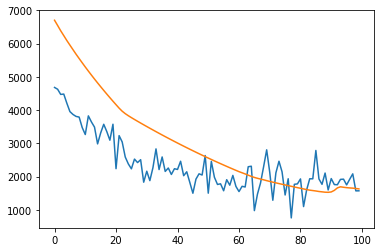

In [16]:
import matplotlib.pyplot as plt

plt.plot(training_losses)
plt.plot(validation_losses)
plt.show()